<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc" style="margin-top: 1em;"><ul class="toc-item"><li><span><a href="#Load-predictions-and-GT" data-toc-modified-id="Load-predictions-and-GT-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Load predictions and GT</a></span></li><li><span><a href="#Static-thresholds" data-toc-modified-id="Static-thresholds-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Static thresholds</a></span></li><li><span><a href="#NumThresh" data-toc-modified-id="NumThresh-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>NumThresh</a></span></li><li><span><a href="#SGLthresh" data-toc-modified-id="SGLthresh-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>SGLthresh</a></span></li><li><span><a href="#heuThresh" data-toc-modified-id="heuThresh-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>heuThresh</a></span></li></ul></div>

In [1]:
import os
os.environ["MKL_NUM_THREADS"] = "2"
os.environ["NUMEXPR_NU M_THREADS"] = "2"
os.environ["OMP_NUM_THREADS"] = "2"

import numpy as np

import matplotlib.pyplot as plt
import matplotlib.cm as cm
from mpl_toolkits.axes_grid1 import make_axes_locatable

from sklearn.metrics import confusion_matrix, accuracy_score, f1_score, precision_recall_fscore_support, classification_report
from sklearn.model_selection import KFold

import pickle
import time
import tqdm

import torch 
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data

# Device configuration
device = 'cpu'
print(device)
# device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
# device = torch.device('cuda:1' if torch.cuda.is_available() else 'cpu')
# print(device, torch.cuda.get_device_name(0))

print("pytorch version:", torch.__version__)


cpu
pytorch version: 1.4.0


In [2]:
torch.manual_seed(0)
torch.cuda.manual_seed(0)
np.random.seed(0)

torch.backends.cudnn.deterministic = True

In [3]:
def print_scores(gt_y, preds):
    print(classification_report(gt_y, preds, digits=3))    
    set_accuracy = accuracy_score(gt_y, preds)
    print('set acc: %.3f'%(set_accuracy))


def print_thresholds(thresh, nb_classes):
    s=''
    for k in range(nb_classes):
        s += '%.3f '%(thresh[k])
    print(s)

    
def save_thresholds_to_text(thresh, fpath):
    nb_classes = len(thresh)
    with open(fpath, 'wt') as fh:
        for k in range(nb_classes):
            fh.write("%.6f\n"%(thresh[k]))
        

def save_thresholds(thresh, fpath):
    np.save(fpath, np.array(thresh))

    
def load_thresholds(fpath):
    return np.load(fpath)


def binarize_probs(probs, thresholds):
    
    nb_classes = probs.shape[-1]
    binarized_output = np.zeros_like(probs)
    
    for k in range(nb_classes):
        binarized_output[:, k] = (np.sign(probs[:, k] - thresholds[k]) + 1) // 2
    
    return binarized_output


# Load predictions and GT

In [4]:
# # Cnn10
# val_pred_np = torch.load('datasets/audioset/Cnn10/eval_clipwise_predictions.pth')
# val_gt_np = torch.load('datasets/audioset/Cnn10/eval_target.pth')

# Cnn14
val_pred_np = torch.load('datasets/audioset/Cnn14/eval_clipwise_predictions.pth')
val_gt_np = torch.load('datasets/audioset/Cnn14/eval_target.pth')

nb_classes=val_gt_np.shape[1]
print(nb_classes)

val_pred_np.shape, val_gt_np.shape

527


((20371, 527), (20371, 527))

In [5]:
s = np.sum(val_gt_np, axis=1)
keep_ind = np.where(s > 0)
# new_val_gt_np = val_gt_np.copy()
val_gt_np = val_gt_np[keep_ind]
val_pred_np = val_pred_np[keep_ind]
# s = np.sum(new_val_gt_np, axis=1)
# new_val_gt_np.shape, np.where(s < 1)
val_gt_np.shape, val_pred_np.shape

((19437, 527), (19437, 527))

In [6]:
val_pred_tensor = torch.tensor(val_pred_np)
val_gt_tensor = torch.tensor(val_gt_np)

In [7]:
s = np.sum(val_gt_np, axis=0)
# plt.hist(s, bins=100)
# s

In [8]:
# noise = torch.normal(mean=0.1*torch.ones(val_pred_np.shape), std=0.1)
# noise = torch.clamp(noise, 0, 1)

In [9]:
# plt.hist(noise[:,0].cpu().numpy())

In [10]:
kf = KFold(n_splits=3, shuffle=True, random_state=0)
kf.get_n_splits(val_gt_np)

print(kf)

KFold(n_splits=3, random_state=0, shuffle=True)


In [11]:
fold_ind = 0
for val_index, test_index in kf.split(val_gt_np):
    val_gt_np_fold, eval_gt_np_fold = val_gt_np[val_index], val_gt_np[test_index]
    val_pred_np_fold, eval_pred_np_fold = val_pred_np[val_index], val_pred_np[test_index]
    print("fold:", fold_ind, "VAL:", val_index.shape, "TEST:", test_index.shape)
    print(val_index[:3], test_index[:3])
    fold_ind += 1

fold: 0 VAL: (12958,) TEST: (6479,)
[0 1 2] [ 8  9 12]
fold: 1 VAL: (12958,) TEST: (6479,)
[1 4 8] [0 2 3]
fold: 2 VAL: (12958,) TEST: (6479,)
[0 2 3] [ 1  4 10]


In [139]:
tmp = np.array([0.508, 0.516, 0.518])
np.std(tmp)

0.0043204937989385775

# Static thresholds

In [10]:
static_thresh = 0.5

mean_micro_f1 = [0, 0]

fold_ind = 0
for val_index, test_index in kf.split(val_gt_np):
    val_gt_np_fold, eval_gt_np_fold = val_gt_np[val_index], val_gt_np[test_index]
    val_pred_np_fold, eval_pred_np_fold = val_pred_np[val_index], val_pred_np[test_index]
    print("fold:", fold_ind, "VAL:", val_index.shape, "TEST:", test_index.shape)

    val_bin_pred = binarize_probs(val_pred_np_fold, [static_thresh]*nb_classes)
    test_bin_pred = binarize_probs(eval_pred_np_fold, [static_thresh]*nb_classes)

    #     print_scores(val_gt_np_fold, val_bin_pred)
    f1 = f1_score(val_gt_np_fold, val_bin_pred, average='micro')
    mean_micro_f1[0] += f1
    print(" val: %.3f"%f1)
    
#     print_scores(eval_gt_np_fold, test_bin_pred)
    f1 = f1_score(eval_gt_np_fold, test_bin_pred, average='micro')
    print(" test: %.3f"%f1)
    mean_micro_f1[1] += f1
    
    fold_ind += 1
    

print("Average micro F1 (val, eval): %.3f %.3f"%(mean_micro_f1[0]/fold_ind, mean_micro_f1[1]/fold_ind))
# Cnn10
# thresh=0.3 Average micro F1 (val, eval): 0.496 0.496
# thresh=0.5 Average micro F1 (val, eval): 0.462 0.462

# Cnn14
# thresh=0.3 Average micro F1 (val, eval): 0.536 0.536
# thresh=0.5 Average micro F1 (val, eval): 0.507 0.507

fold: 0 VAL: (12958,) TEST: (6479,)
 val: 0.505
 test: 0.512
fold: 1 VAL: (12958,) TEST: (6479,)
 val: 0.508
 test: 0.505
fold: 2 VAL: (12958,) TEST: (6479,)
 val: 0.508
 test: 0.505
Average micro F1 (val, eval): 0.507 0.507


In [11]:
tmp = np.array([0.504, 0.511, 0.506])
np.std(tmp)*100

0.29439202887759514

In [46]:
# print("val")
# print_scores(val_gt_np, val_bin_pred)
# print("test")
# print_scores(desed_gt_np, test_bin_pred)

# f1 = f1_score(val_gt_np, val_bin_pred, average='micro')
# print("%.3f"%f1)

# myf1 = my_calculate_f1(val_gt_np, val_pred_np, thresholds=[static_thresh]*nb_classes, average='micro')
# print("%.3f"%myf1)

# binarized_output = np.zeros_like(val_gt_np)
#     #     print('class num:', classes_num)
# thresholds=[static_thresh]*nb_classes
# for k in range(nb_classes):
#     binarized_output[:, k] = (np.sign(val_pred_np[:, k] - thresholds[k]) + 1) // 2

# np.allclose(val_bin_pred, binarized_output)
# # val_bin_pred[:10], binarized_output[:10]

# NumThresh

In [68]:
from sgl_utils.opt import Adam
from sgl_utils.numThresh import calculate_f1, calculate_at_gradient, optimize_at_with_gd, optimize_prec_and_rec_with_gd, calculate_prec_and_rec_gradient, calculate_prec_and_rec
from sklearn import metrics

In [70]:
t=0.3
thresh = [t]*nb_classes

average = 'micro'

manual_thres_f1 = calculate_f1(val_gt_np, val_pred_np, thresholds=thresh, average=average)
# print_scores(y_test_numpy, test_pred)

# Optimize thresholds
time1 = time.time()
(auto_thres_f1, auto_thresholds, metric_asfo_epoch) = optimize_at_with_gd(val_gt_np, val_pred_np, 
                                                                          thresh, average=average)
# (auto_thres_f1, auto_thresholds, metric_asfo_epoch) = optimize_prec_and_rec_with_gd(val_gt_np, val_pred_np, 
#                                                                           thresh, average=average)
optimizing_time = time.time() - time1

print('optimizing time: {:.3f} s'
        ''.format(optimizing_time))

# print_thresholds(auto_thresholds, nb_classes)
# print("%.3f %.3f"%(manual_thres_f1*100, fscore2*100))

print('val manual_thres f1: {:.3f}'.format(manual_thres_f1))
print('val auto_thres f1: {:.3f}'.format(auto_thres_f1))

print(auto_thres_f1)
print_thresholds(auto_thresholds, nb_classes)

# optimizing time: 485941.614 s
# val manual_thres f1: 0.536
# val auto_thres f1: 0.556

Iteration: 0, Score: 0.537, thresholds: [0.30918073 0.29499427 0.29722259 0.29335832 0.30105206 0.30207003
 0.29499427 0.29722259 0.30056438 0.30026439 0.29722259 0.3053592
 0.29810739 0.29655758 0.29699582 0.29655758 0.30056438 0.30332586
 0.29846767 0.29499427 0.30389719 0.29655758 0.30105206 0.30207003
 0.29499427 0.30207006 0.29904072 0.30928359 0.293132   0.30207003
 0.29655751 0.30207003 0.30070354 0.30646042 0.30105206 0.29499427
 0.30207003 0.29810739 0.29655758 0.29722259 0.30207003 0.30207003
 0.29856929 0.29904072 0.2981968  0.29499427 0.30207003 0.30207003
 0.29499427 0.3053592  0.30207003 0.30105206 0.29810739 0.30207003
 0.29499427 0.2981968  0.29722259 0.29722259 0.29722259 0.29810739
 0.30105206 0.30207003 0.29856929 0.29243572 0.30070355 0.293132
 0.29164058 0.29499427 0.30207003 0.30056438 0.29499427 0.30207003
 0.30401033 0.30258978 0.30389719 0.30105206 0.30389719 0.30207003
 0.30207003 0.29164058 0.30646042 0.30207003 0.30052823 0.30207003
 0.30389719 0.29655758 0.

In [102]:
485941/(24*3600),0.624317129629629*24

(5.624317129629629, 14.983611111111097)

(array([0.5325, 0.535 , 0.5375, 0.54  , 0.5425, 0.545 , 0.5475, 0.55  ,
        0.5525, 0.555 , 0.5575]),
 <a list of 11 Text yticklabel objects>)

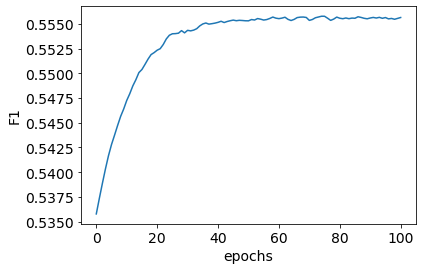

In [71]:
fontsize=14
plt.plot(metric_asfo_epoch)
plt.xlabel("epochs", fontsize=fontsize)
plt.ylabel("F1", fontsize=fontsize)
plt.xticks(fontsize=fontsize)
plt.yticks(fontsize=fontsize)
# plt.savefig("datasets/emotions/emotions_F1_asof_epochs_myNetwork.png")

In [90]:
# print_thresholds(learned_AT_thresholds, nb_classes)

val_bin_pred = binarize_probs(val_pred_np, auto_thresholds)
# test_bin_pred = binarize_probs(desed_pred_np, auto_thresholds)

print('val')
print_scores(val_gt_np, val_bin_pred)
# print('desed')
# print_scores(desed_gt_np, test_bin_pred)

val


/home/thomas/tools/miniconda2/envs/envPytorch1/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/thomas/tools/miniconda2/envs/envPytorch1/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           0      0.669     0.920     0.775      5036
           1      0.286     0.098     0.146        61
           2      0.200     0.029     0.051        68
           3      0.528     0.440     0.480       193
           4      0.000     0.000     0.000        56
           5      0.200     0.017     0.032        58
           6      0.543     0.746     0.629        59
           7      0.645     0.351     0.455        57
           8      0.308     0.069     0.113        58
           9      0.500     0.018     0.035        55
          10      0.353     0.102     0.158        59
          11      0.308     0.143     0.195        56
          12      0.828     0.800     0.814        60
          13      0.578     0.627     0.602        59
          14      0.559     0.352     0.432        54
          15      0.662     0.789     0.720        57
          16      0.478     0.491     0.485       112
          17      0.468    

# SGLthresh

In [12]:
from sgl_utils.sglThresh import ThresholdModel, SurrogateHeaviside, F1_loss_objective, macro_F1_loss_objective

Device in sglThresh.py cpu


fold: 0 VAL: (12958,) TEST: (6479,)
Epoch [1/100], Loss: -0.5325, Duration: 0.3 s
Epoch [51/100], Loss: -0.5643, Duration: 0.2 s
 val: 0.565 macro=0.429
 test: 0.553macro=0.400
fold: 1 VAL: (12958,) TEST: (6479,)
Epoch [1/100], Loss: -0.5364, Duration: 0.3 s
Epoch [51/100], Loss: -0.5670, Duration: 0.2 s
 val: 0.567 macro=0.431
 test: 0.548macro=0.397
fold: 2 VAL: (12958,) TEST: (6479,)
Epoch [1/100], Loss: -0.5382, Duration: 0.2 s
Epoch [51/100], Loss: -0.5686, Duration: 0.3 s
 val: 0.569 macro=0.431
 test: 0.543macro=0.395
Average micro F1 (val, eval): 0.567 0.548
Average macro F1 (val, eval): 0.430 0.397
Duration: 3.111


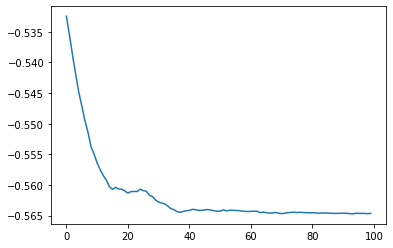

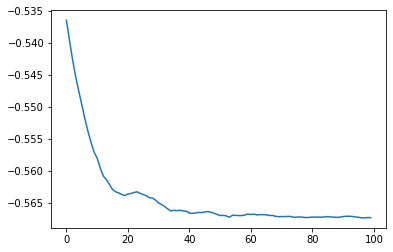

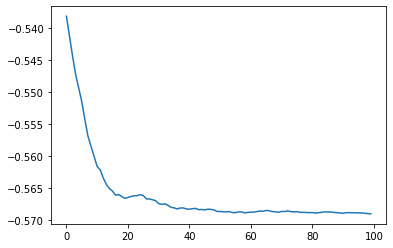

In [13]:
criterion = F1_loss_objective
# criterion = macro_F1_loss_objective


# num_epochs = 150
num_epochs = 100
# num_epochs = 300

mean_micro_f1 = [0, 0]
mean_macro_f1 = [0, 0]

debut=time.time()

fold_ind = 0
for val_index, test_index in kf.split(val_gt_np):
    
    val_gt_np_fold, eval_gt_np_fold = val_gt_np[val_index], val_gt_np[test_index]
    val_pred_np_fold, eval_pred_np_fold = val_pred_np[val_index], val_pred_np[test_index]
    
    val_gt_tensor = torch.tensor(val_gt_np_fold).to(device)
    val_pred_tensor = torch.tensor(val_pred_np_fold).to(device)

    print("fold:", fold_ind, "VAL:", val_index.shape, "TEST:", test_index.shape)

    THRESHmodel = ThresholdModel(threshold_fn=SurrogateHeaviside.apply, t=0.3, sigma=50., nb_classes=nb_classes)
    THRESHmodel = THRESHmodel.to(device, dtype=torch.float)

    learning_rate = 1e-2

    # # learn only the thresholds:
#     THRESHoptimizer = torch.optim.Adam([
#                     {'params': THRESHmodel.thresh}
#                 ], lr=learning_rate)

    # # or the thresholds and sigma
    THRESHoptimizer = torch.optim.Adam(THRESHmodel.parameters(), lr=learning_rate)

    
    cumul_delta_thresh = torch.zeros(nb_classes,)
    delta_thresh = torch.zeros(nb_classes,)

    el = next(THRESHmodel.parameters())
    PREC_learned_AT_thresholds = el.clone().detach().cpu()
#     print(PREC_learned_AT_thresholds)

    losses = []
    for epoch in range(num_epochs):

        debut = time.time()

        THRESHmodel.train()

        # Forward pass
        outputs = THRESHmodel(val_pred_tensor)

        loss = criterion(outputs, val_gt_tensor)

        # Backward and optimize
        THRESHoptimizer.zero_grad()

        loss.backward()
    #     loss.mean().backward()
    #         loss.backward(at_batch_y)
        # loss.backward(torch.ones_like(loss))

        THRESHoptimizer.step()
        # THRESHmodel.clamp()
        losses.append(loss)

        duree_epoch = time.time() - debut
        if epoch % 50 == 0:
            print ('Epoch [{}/{}], Loss: {:.4f}, Duration: {:.1f} s' 
                   .format(epoch+1, num_epochs, loss, duree_epoch))

        learned_AT_thresholds = THRESHmodel.thresh.clone().detach().cpu()

        delta_thresh = learned_AT_thresholds - PREC_learned_AT_thresholds
        cumul_delta_thresh += delta_thresh
        PREC_learned_AT_thresholds = learned_AT_thresholds
#         if epoch % 10 == 0: 
#             print('threshs:', learned_AT_thresholds)
#             print('sigma:', THRESHmodel.sigma.clone().detach().cpu())
        # if torch.sum(delta_thresh) < 0.01: break

#     print('delta:', cumul_delta_thresh)
    plt.figure()
    # plt.figure(figsize=(8,6))
    plt.plot(losses)
    
    learned_AT_thresholds=THRESHmodel.thresh.clone().detach().cpu().numpy()
    sigma = THRESHmodel.sigma.clone().detach().cpu().numpy()
#     print(sigma)
    
    val_bin_pred = binarize_probs(val_pred_np_fold, learned_AT_thresholds)
    test_bin_pred = binarize_probs(eval_pred_np_fold, learned_AT_thresholds)

    #     print_scores(val_gt_np_fold, val_bin_pred)
    f1 = f1_score(val_gt_np_fold, val_bin_pred, average='micro')
    macro_f1 = f1_score(val_gt_np_fold, val_bin_pred, average='macro')
    mean_micro_f1[0] += f1
    mean_macro_f1[0] += macro_f1
    print(" val: %.3f macro=%.3f"%(f1, macro_f1))
    
#     print_scores(eval_gt_np_fold, test_bin_pred)
    f1 = f1_score(eval_gt_np_fold, test_bin_pred, average='micro')
    macro_f1 = f1_score(eval_gt_np_fold, test_bin_pred, average='macro')
    print(" test: %.3fmacro=%.3f"%(f1, macro_f1))
    mean_micro_f1[1] += f1
    mean_macro_f1[1] += macro_f1
    
    save_thresholds(learned_AT_thresholds, "exp/audioset/sgl/macroF1_thresholds_fold%d.npy"%(fold_ind))
    
    fold_ind += 1
    

print("Average micro F1 (val, eval): %.3f %.3f"%(mean_micro_f1[0]/fold_ind, mean_micro_f1[1]/fold_ind))
print("Average macro F1 (val, eval): %.3f %.3f"%(mean_macro_f1[0]/fold_ind, mean_macro_f1[1]/fold_ind))
print("Duration: %.3f"%(time.time()-debut))

# Cnn10

## static 
### thresh=0.3 Average micro F1 (val, eval): 0.496 0.496
#### thresh=0.5 Average micro F1 (val, eval): 0.462 0.462

## SGLThresh
### init thresh=0.3 Average micro F1 (val, eval): 0.530 0.509
### init thresh=0.5 Average micro F1 (val, eval): 0.525 0.504


# Cnn14

## static 
### thresh=0.3 Average micro F1 (val, eval): 0.536 0.536
### thresh=0.5 Average micro F1 (val, eval): 0.507 0.507

## SGLThresh
### init thresh=0.3 Average micro F1 (val, eval): 0.567 0.548
### init thresh=0.5 Average micro F1 (val, eval): 0.563 0.543

# Objective: macro F1
# Average micro F1 (val, eval): 0.553 0.539
# Average macro F1 (val, eval): 0.448 0.422

# Objective: micro F1
# Average micro F1 (val, eval): 0.567 0.548
# Average macro F1 (val, eval): 0.430 0.397

In [99]:
tmp = np.array([0.544, 0.550, 0.550])
np.std(tmp)*100


0.2828427124746193

# heuThresh

In [73]:
from heu_utils.heuThresh import heu_threshold_opti

In [75]:
t=0.5
thresh = [t]*nb_classes

time1 = time.time()

sk_f1, best_f1, best_AT_thresholds, history = heu_threshold_opti(val_gt_np, val_pred_np, thresh)

optimizing_time = time.time() - time1
print('optimizing time: {:.3f} s'
        ''.format(optimizing_time))

# optimizing time: 41472.337 s

optimizing time: 41472.337 s


In [108]:
41472.337/(3600), 60*.5200

(11.520093611111111, 31.200000000000003)

In [77]:
val_bin_pred = binarize_probs(val_pred_np, best_AT_thresholds)
# test_bin_pred = binarize_probs(desed_pred_np, best_AT_thresholds)

# print(val_bin_pred)

print('val')
print_scores(val_gt_np, val_bin_pred)


val


/home/thomas/tools/miniconda2/envs/envPytorch1/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/thomas/tools/miniconda2/envs/envPytorch1/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           0      0.711     0.875     0.785      4101
           1      0.203     0.264     0.230        53
           2      0.261     0.218     0.238        55
           3      0.529     0.525     0.527       158
           4      0.246     0.320     0.278        50
           5      0.114     0.438     0.180        48
           6      0.593     0.729     0.654        48
           7      0.446     0.543     0.490        46
           8      0.281     0.348     0.311        46
           9      0.237     0.205     0.220        44
          10      0.188     0.302     0.232        43
          11      0.210     0.667     0.319        45
          12      0.790     0.907     0.845        54
          13      0.596     0.620     0.608        50
          14      0.432     0.400     0.416        40
          15      0.756     0.756     0.756        45
          16      0.591     0.481     0.531        81
          17      0.952    

In [78]:
# print_thresholds(best_AT_thresholds, nb_classes)